In [1]:
import numpy as np
import tensorflow_probability as tfp
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import math
import os
import random
import string
import logging
import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pathlib

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
# connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

D0823 18:44:34.453016806  696569 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0823 18:44:34.453037995  696569 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0823 18:44:34.453043781  696569 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0823 18:44:34.453054140  696569 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0823 18:44:34.453058821  696569 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0823 18:44:34.453063501  696569 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0823 18:44:34.453068165  696569 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0823 18:44:34.

Found 3670 files belonging to 5 classes.


tcmalloc: large alloc 2886205440 bytes == 0x144212000 @  0x7f97cab6f680 0x7f97cab90824 0x7f97c0571994 0x7f97c057212f 0x7f97c05d08f5 0x7f97c05d3b1a 0x7f97c05d4017 0x7f97c0671255 0x5c4dd7 0x570556 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3 0x50b17c 0x5f60b2 0x56ccfc
tcmalloc: large alloc 2886205440 bytes == 0x348df8000 @  0x7f97cab6f680 0x7f97cab90824 0x7f97c0571994 0x7f97c057212f 0x7f97c05d08f5 0x7f97c05d0a56 0x7f97c07e738c 0x7f97c07eff3e 0x5f40f1 0x5f43b5 0x7f97c068be0c 0x50ed6c 0x56cbf4 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3
tcmalloc: large alloc 2886205440 bytes == 0x144212000 @  0x7f97cab6f680 0x7f97cab90824 0x7f97cab90b8a 0x7f971c564bd4 0x7f971d019b75 0x7f971d0c2aed 0x7f971cee860e 0x7f971cee91fe 0x7f971cee9409 0x7f970946b184 0x7f971d18fb6d 0x7f

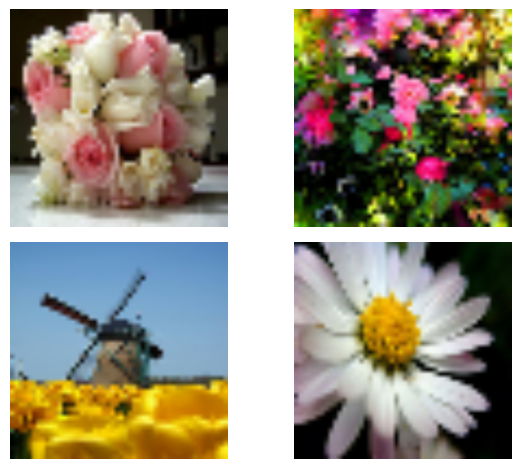

In [3]:
data_dir = "flower_photos"
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, seed=123, image_size=(256, 256), batch_size=1)
original_array = []
for index, i in enumerate(train_ds):
    if index < 10000:
        original_array.append(i[0][0])
original_array = np.array(original_array)
original_array = (original_array) / 255.

low_quality = tf.image.resize(original_array, [50, 50])
low_quality = tf.image.resize(low_quality, [256, 256])
low_quality = np.array(low_quality)

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(low_quality[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((low_quality[4:], original_array[4:]))
train_set = train_set.batch(64, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)

def get_model(upscale_factor=3, channels=3):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = tf.keras.Input(shape=(None, None, channels))
    x = tf.keras.layers.Conv2D(256, 5, **conv_args)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, **conv_args)(x)
    x = tf.keras.layers.Conv2D(64, 3, **conv_args)(x)
    x = tf.keras.layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)
    # outputs = tf.keras.activations.sigmoid(outputs)

    return tf.keras.Model(inputs, outputs)

with strategy.scope():
    modejl = get_model(upscale_factor=4, channels=3)
    model.summary()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE))
    model.fit(train_set, epochs=20)

In [ ]:
blury_images = original_array[:4]
blury_images = tf.image.resize(blury_images, [64, 64])

pred_images = model.predict(blury_images)
x = ((pred_images-np.min(pred_images))/(np.max(pred_images)-np.min(pred_images)))

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(pred_images[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [3]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units=128, activation='relu'):
        super(FeedForward, self).__init__()

        self.dense = tf.keras.layers.Dense(units)
        self.norm = tf.keras.layers.LayerNormalization()
        self.act = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        outputs = self.dense(inputs)
        outputs = self.norm(outputs)
        outputs = self.act(outputs)

        return outputs


class SinusoidalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dims=128, embedding_min_frequency=1.0, embedding_max_frequency=1000.0):
        super(SinusoidalEmbedding, self).__init__()

        self.embedding_min_frequency = embedding_min_frequency
        self.embedding_max_frequency = embedding_max_frequency
        self.embedding_dims = embedding_dims

    def call(self, x):

        frequencies = tf.exp(
        tf.linspace(tf.math.log(self.embedding_min_frequency),
                    tf.math.log(self.embedding_max_frequency),
                    self.embedding_dims // 2))

        angular_speeds = 2.0 * math.pi * frequencies
        embeddings = tf.concat(
            [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)],
            axis=3)

        return embeddings

class Block(tf.keras.layers.Layer):
    def __init__(self, filters=128, kernel_size=3, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_1 = tf.keras.layers.Conv2D(filters, 1, padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='swish')
        self.conv_3 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')

        self.norm_1 = tf.keras.layers.BatchNormalization(center=False, scale=False)


    def call(self, x_img):

        x_r = self.conv_1(x_img)

        x_out = self.norm_1(x_img)
        x_out = self.conv_2(x_out)
        x_out = self.conv_3(x_out)
        x_out += x_r

        return x_out
    
    def get_config(self, **kwargs):
        config = super().get_config(**kwargs)
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
        })
        return config

In [5]:
class UNet(tf.keras.models.Model):
    def __init__(self, out_channels=3, image_size=32, depth=3, copy_rate=0.999, init_filter=256):
        super(UNet, self).__init__(name='unet')

        self.depth = depth
        self.init_filter = init_filter
        self.up_and_down_filters = [128, 128, 128]
        self.mid_filters = [128, 128]
        self.image_shape = (image_size, image_size, out_channels)
        self.copy_rate = copy_rate
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

        self.min_signal_rate = 0.02
        self.max_signal_rate = 0.95

        self.norm = tf.keras.layers.Normalization(mean=0, variance=1)
        self.norm_1 = tf.keras.layers.Normalization(mean=0, variance=1)

        self.norm_group = tf.keras.layers.GroupNormalization()
        self.activation = tf.keras.activations.swish

        self.training_model = self.model_n(self.image_shape)
        self.generation_model = self.model_n(self.image_shape)

        self.conv_layers = [tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same") for _ in range(4)] + [tf.keras.layers.Conv2D(3, kernel_size=1, padding="same")]
        self.num_channels = 3
        
        

    def model_n(self, image_shape,):

        image_with_noise = tf.keras.Input(shape=image_shape)
       
        time_steps = tf.keras.Input(shape=(1, 1, 1))
        t = SinusoidalEmbedding(embedding_dims=self.init_filter)(time_steps)
        x_ts = tf.keras.layers.UpSampling2D(size=image_shape[1], interpolation="nearest")(t)

        x = tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same")(image_with_noise)
        x = tf.keras.layers.Concatenate()([x, x_ts])


        # down
        down_history = []
        for filter in self.up_and_down_filters:
            for _ in range(self.depth):
                x = Block(filter)(x)
                down_history.append(x)
            x = tf.keras.layers.MaxPool2D(2)(x)

        # mlp
        for filter in self.mid_filters:
            x = Block(filter)(x)

        # up
        for filter in reversed(self.up_and_down_filters):

            x = tf.keras.layers.UpSampling2D(2, interpolation="bilinear")(x)
            for _ in range(self.depth):
                x = tf.keras.layers.Concatenate()([x, down_history.pop()])
                x = Block(filter)(x)

        x = self.norm_group(x)
        x = self.activation(x)
        x = tf.keras.layers.Conv2D(image_shape[-1], kernel_size=1, padding="same", kernel_initializer="zeros")(x)

        return tf.keras.Model([image_with_noise, time_steps], x)

    def call(self, inputs, training):

        noisy_images, noise_rates, signal_rates = inputs

            
        if training:
            model_used = self.training_model
        else:
            model_used = self.generation_model

        pred_noises = model_used([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def train_step(self, high_q):

        nbs = tf.shape(high_q)[0]
        high_q = self.norm_1(high_q)

        # noisy_images = tf.image.resize(high_q, [64, 64])
        # noisy_images = tf.image.resize(noisy_images, [256, 256])
        # noisy_images = self.norm(noisy_images)
        
        # noises = tf.random.normal((nbs, 256, 256, 3))
        
        low_q = tf.image.resize(high_q, [64, 64])
        low_q = tf.image.resize(low_q, [256, 256])
        low_q = self.norm(low_q)

        noises = low_q - high_q

        diffusion_times = tf.random.uniform(shape=(nbs, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        
        # noises = (noisy_images - signal_rates * high_q)/noise_rates
        noisy_images = signal_rates * high_q + noise_rates * noises

        with tf.GradientTape() as tape:
            
            
            generated_noise, generated_image = self([low_q, noise_rates, signal_rates], training=True)
            loss = self._compute_loss(noises, generated_noise)

        grads = tape.gradient(loss, self.training_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.training_model.trainable_weights))

        for weight, ema_weight in zip(self.training_model.weights, self.generation_model.weights):
            ema_weight.assign(self.copy_rate * ema_weight + (1 - self.copy_rate) * weight)


        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


    def _compute_loss(self, real_noise, pred_noise):

        loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        loss = loss_object(real_noise, pred_noise)
        loss = tf.reduce_sum(loss)
        return loss


    def diffusion_schedule(self, diffusion_times):
        
        # diffusion times to angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def generate(self, initial_image, num_images=1, diffusion_steps=20):

        step_size = 1.0 / diffusion_steps

        next_noisy_images = self.norm(initial_image, training=False)
        # next_noisy_images = tf.random.normal((1, 256, 256, 3))
        # next_noisy_images = initial_image

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self([noisy_images, noise_rates, signal_rates], training=False)

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)

        return pred_images

with strategy.scope():
    train_set = tf.data.Dataset.from_tensor_slices((original_array[4:]))
    train_set = train_set.batch(64, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)

    im_sh = original_array.shape
    model = UNet(out_channels=im_sh[-1], image_size=im_sh[-2])

    optimizer = tf.keras.optimizers.Adam(1e-4)

    # checkpoint_path = './cnmjk_2'
    # ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
    # ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    # # if a checkpoint exists, restore the latest checkpoint.
    # if ckpt_manager.latest_checkpoint:
    #     ckpt.restore(ckpt_manager.latest_checkpoint)
    #     print('Latest checkpoint restored!!')

    # class CustomCallback(tf.keras.callbacks.Callback):
    #     def on_epoch_end(self, epoch, logs=None):
    #         ckpt_save_path = ckpt_manager.save()
    # , callbacks=[CustomCallback()]


    model.compile(optimizer=optimizer)
    model.fit(train_set, epochs=600)

    
    

Epoch 1/600
57/57 [==============================] - 82s 341ms/step - loss: 4383.7178
Epoch 2/600
57/57 [==============================] - 19s 340ms/step - loss: 4409.8579
Epoch 3/600
57/57 [==============================] - 19s 341ms/step - loss: 4246.6147
Epoch 4/600
57/57 [==============================] - 19s 341ms/step - loss: 4481.1885
Epoch 5/600
57/57 [==============================] - 19s 340ms/step - loss: 4361.9209
Epoch 6/600
57/57 [==============================] - 19s 340ms/step - loss: 4362.8306
Epoch 7/600
57/57 [==============================] - 19s 340ms/step - loss: 4319.4287
Epoch 8/600
57/57 [==============================] - 19s 341ms/step - loss: 4414.8735
Epoch 9/600
57/57 [==============================] - 20s 342ms/step - loss: 4258.2158
Epoch 10/600
57/57 [==============================] - 19s 340ms/step - loss: 4304.6670
Epoch 11/600
57/57 [==============================] - 19s 340ms/step - loss: 4337.9478
Epoch 12/600
57/57 [==============================] 

In [ ]:

pred_images = model.generate(low_quality[:4], num_images=4, diffusion_steps=20)
x = (pred_images - np.min(pred_images))/(np.max(pred_images) - np.min(pred_images))
# x = model.norm_1.mean + pred_images * model.norm_1.variance**0.5
# x = tf.clip_by_value(x, 0.0, 1.0)

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(x[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()